# How to use this notebook

All the data required for this tutorial is readily available in our public repository. To access this valuable resource, we kindly ask users to clone the repository or download its contents by visiting the following link: [Betteromics Examples Repository](https://github.com/betteromics/betteromics-examples/archive/refs/heads/main.zip) and following the instructions in the README. By doing so, you will gain seamless access to all the necessary datasets and materials, ensuring a smooth and enriching experience as you delve into our tutorials and explore the diverse world of Betteromics.


In the notebook cell below, replace `~/betteromics-examples/` with the full path to the directory where you have downloaded the repository. This adjustment will ensure that the script correctly accesses the required data and resources from your local setup.

In [1]:
from IPython.display import clear_output
import warnings
import os

warnings.filterwarnings("ignore")
os.chdir(os.path.expanduser("~/betteromics-examples/"))

When a user runs the cell below, it will check for the required libraries and automatically install any missing ones for this tutorial.

In [2]:
%%capture
!python -m pip install -r python/examples/tcga/requirements_python.txt

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Betteromics API access

In order to connect with Betteromics environment, we need to import the 'util' file below. You can find this in this repo, under `python/util.py`.

This utill file serves as the essential bridge that connects us to the Betteromics API, enabling us to access the wealth of public data and relevant tables it offers. This file contains all the necessary functions and configurations to ensure a smooth and efficient link-up with Betteromics, making it super easy for us to fetch the data we need for our projects. By including this file in our project, we ensure that we can efficiently retrieve, process, and analyze the data from Betteromics, unlocking valuable insights and empowering our work with the comprehensive resources it provides. 

Please ensure you log in to the [Betteromics Public Demo Page](https://public-demo.betteromics.com/) and then proceed to follow the instructions provided in the cell below to gain access to the data.

In [4]:
from python.utils import *

clear_output(wait=False)

# Access data using SQL 

SQL, which stands for Structured Query Language, is a powerful and standardized programming language used for managing and manipulating relational databases. SQL allows users to interact with databases and retrieve data. At Betteromics, SQL serves as a pivotal tool that empowers users to seamlessly access the data they need. We've already taken the initiative to ingest the publicly available TCGA (The Cancer Genome Atlas) data, making it readily accessible to our users. One way to explore this valuable dataset is by querying the `tcga_pancreatic_cancer_analysis_clinical_with_filenames_latest` table. This table contains a wealth of data related to pancreatic cancer analysis, granting users the ability to perform data-driven research and extract meaningful insights for their work in the field of cancer genomics.

In [5]:
query = """ 

WITH clinical as (
    SELECT 
        case_submitter_id
      , gender
      , days_to_death
      , vital_status
      , race 
      , alcohol_history 
      , pack_years_smoked
      , cancer_type 
      , tissue_or_organ_of_origin   
      , ajcc_clinical_stage
      , ajcc_pathologic_stage
      , abbreviated_cancer_type
      , age_at_diagnosis AS age_at_diagnosis_days
      , CAST (age_at_diagnosis AS INT) / 365 AS age_at_diagnosis_years
    
    FROM tcga_pancreatic_cancer_analysis_clinical_with_filenames_latest  
    WHERE abbreviated_cancer_type = 'Pancreatic'
  )
  
SELECT * FROM clinical
"""

pc = create_dataframe_from_query(query)  # pc stands for Pancreatic Cancer
pc.head()

,case_submitter_id,gender,days_to_death,vital_status,race,alcohol_history,pack_years_smoked,cancer_type,tissue_or_organ_of_origin,ajcc_clinical_stage,ajcc_pathologic_stage,abbreviated_cancer_type,age_at_diagnosis_days,age_at_diagnosis_years
0,TCGA-IB-7897,Female,486.0,Dead,White,Yes,0.0,Pancreatic adenocarcinoma,"Pancreas, NOS",Not Reported,IIB,Pancreatic,19718,54
1,TCGA-HZ-8315,Female,299.0,Dead,White,Not reported,0.0,Pancreatic adenocarcinoma,Head of pancreas,Not Reported,IIA,Pancreatic,19839,54
2,TCGA-HZ-8636,Female,545.0,Dead,White,No,0.0,Pancreatic adenocarcinoma,Tail of pancreas,Not Reported,IV,Pancreatic,21501,58
3,TCGA-IB-7888,Female,1332.0,Dead,Black or African American,No,0.0,Pancreatic adenocarcinoma,"Pancreas, NOS",Not Reported,IIA,Pancreatic,24117,66
4,TCGA-IB-7893,Male,117.0,Dead,White,Yes,0.0,Pancreatic adenocarcinoma,"Pancreas, NOS",Not Reported,IIA,Pancreatic,23703,64


## Data Wrangling and Data Exploration
Let's take a quick dive into this data to gain a better understanding of pancreatic cancer mortality.

In [6]:
pc["vital_status"].value_counts(dropna=False)

Dead     89
Alive    83
Name: vital_status, dtype: int64

In [7]:
# making the vital status into binary
pc["is_dead"] = pc["vital_status"].map({"Dead": 1, "Alive": 0})

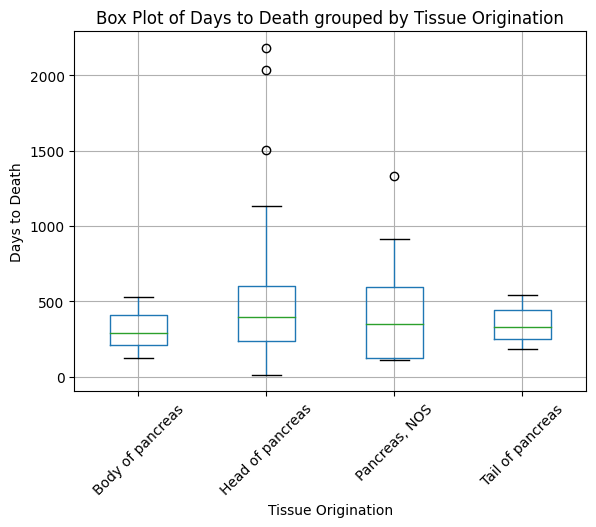

In [8]:
# Use the boxplot function to create the box plots
pc[pc.tissue_or_organ_of_origin != "Overlapping lesion of pancreas"].boxplot(
    column=["days_to_death"], by="tissue_or_organ_of_origin"
)

plt.xticks(rotation=45)
plt.xlabel("Tissue Origination")
plt.ylabel("Days to Death")
plt.suptitle("")
plt.title("Box Plot of Days to Death grouped by Tissue Origination")

plt.show()

# Survival Analysis
A **Kaplan-Meier** plot, often referred to as a survival curve, is a graphical representation used in survival analysis to visualize the probability of an event, typically the survival of a group of individuals, over time. It is especially valuable when studying time-to-event data, such as time to disease recurrence, patient survival, or any event of interest in various fields like medicine, epidemiology, and engineering. The Kaplan-Meier plot provides insights into the probability of an event occurring at different time points while accounting for censored data, where events have not yet occurred or are lost to follow-up. This visualization allows researchers and data analysts to compare the survival experiences of different groups or cohorts, assess the impact of variables or treatments on survival rates, and make informed decisions in areas such as healthcare planning, clinical trials, and risk assessment.

Kindly be aware that this dataset does not contain right-censored data, and conducting a comprehensive survival analysis is beyond the intended scope of this notebook.

In [9]:
# Let's say people who stayed alive follow the current life expectancy for U.S. in 2023 which is ~79 years

DAYS_IN_YEAR = 365
life_expectency = 79.11  # Data source: https://population.un.org/wpp/

life_expectency_in_days = life_expectency * DAYS_IN_YEAR
TIME_CUTOFF = DAYS_IN_YEAR

In [10]:
maximum_days_before_death_from_data = pc["days_to_death"].max()
pc["days_to_death"] = pc["days_to_death"].fillna(life_expectency_in_days - pc["age_at_diagnosis_days"])

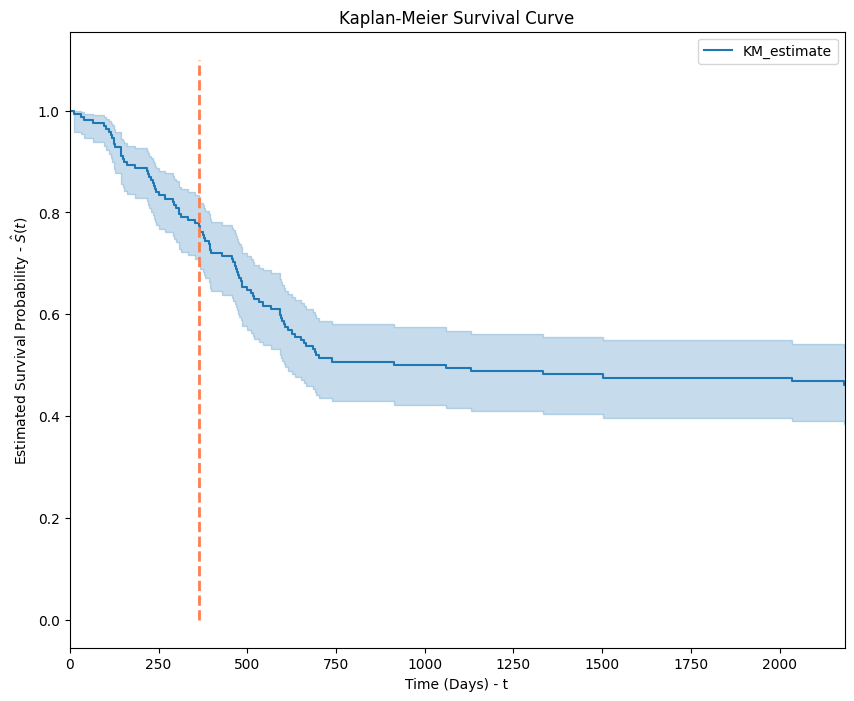

In [11]:
from lifelines import KaplanMeierFitter

# Initialize the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier survival curve
kmf.fit(pc["days_to_death"], event_observed=pc["is_dead"])

# Create the Kaplan-Meier plot
plt.figure(figsize=(10, 8))
kmf.plot()
plt.title("Kaplan-Meier Survival Curve")
plt.xlim([-1, maximum_days_before_death_from_data + 1])
plt.xlabel("Time (Days) - t")
plt.ylabel("Estimated Survival Probability - $\hat{S}(t)$")
plt.vlines(TIME_CUTOFF, 0, 1.1, lw=2, linestyles="--", color="coral")

## Including some of the covariates

In [12]:
# making the alcohol_history into binary
pc["had_alcohol_history"] = pc["alcohol_history"].map(
    {
        "Yes": 1,
        "No": 0,
        "Not reported": 1,
    }
)

## Hazard ratio

The hazard ratio represents the ratio of the hazard (risk of an event) for the group with the covariate value of 1 compared to the group with the reference covariate value (usually 0).

Here's what it means:

Hazard Ratio (HR) Interpretation:

| Magnitude of Effect | Hazard Ratio (HR) | Interpretation                       |
|:---------------------|:-------------------|:-------------------------------------|
| No effect           | HR = 1            | No effect                            |
| Increased hazard    | HR > 1            | An HR greater than 1 suggests an increased hazard or risk of the event (e.g., death) for individuals with an alcohol history compared to non-alcohol-users. |
| Reduced hazard      | HR < 1            | An HR less than 1 would indicate a reduced hazard or a protective effect. |


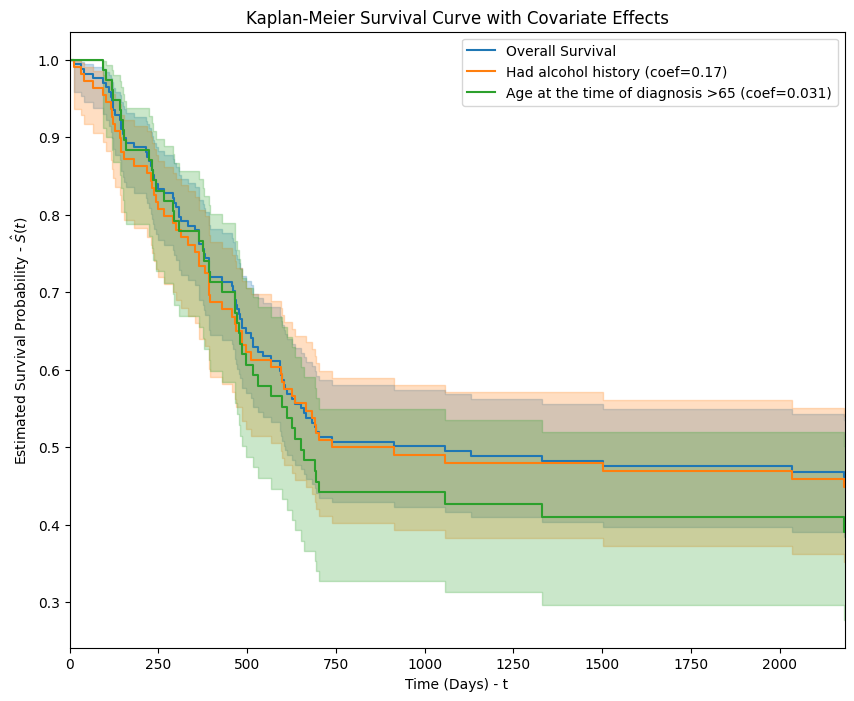

In [13]:
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt

# Initialize the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier survival curve
kmf.fit(pc["days_to_death"], event_observed=pc["is_dead"])

# Create the Kaplan-Meier plot
plt.figure(figsize=(10, 8))
kmf.plot(label="Overall Survival")

# Fit a Cox proportional hazards model with covariates
cph = CoxPHFitter()
cph.fit(
    pc[["days_to_death", "had_alcohol_history", "age_at_diagnosis_years", "is_dead"]],
    duration_col="days_to_death",
    event_col="is_dead",
)

# Extract the coefficients for the covariates
covariate1_coef = cph.summary["coef"]["had_alcohol_history"]
covariate2_coef = cph.summary["coef"]["age_at_diagnosis_years"]


# Create separate Kaplan-Meier plots for each covariate
kmf_covariate1 = KaplanMeierFitter()
kmf_covariate1.fit(
    pc[pc["had_alcohol_history"] == 1]["days_to_death"], event_observed=pc[pc["had_alcohol_history"] == 1]["is_dead"]
)
kmf_covariate1.plot(label=f"Had alcohol history (coef={round(covariate1_coef,3)})")

kmf_covariate2 = KaplanMeierFitter()

AGE_OF_ONSET_PC_70PERCENT = 65
kmf_covariate2.fit(
    pc[pc["age_at_diagnosis_years"] > AGE_OF_ONSET_PC_70PERCENT]["days_to_death"],
    event_observed=pc[pc["age_at_diagnosis_years"] > AGE_OF_ONSET_PC_70PERCENT]["is_dead"],
)

kmf_covariate2.plot(label=f"Age at the time of diagnosis >65 (coef={round(covariate2_coef,3)})")

plt.title("Kaplan-Meier Survival Curve with Covariate Effects")
plt.xlim([0, maximum_days_before_death_from_data + 1])
plt.xlabel("Time (Days) - t")
plt.ylabel("Estimated Survival Probability - $\hat{S}(t)$")
plt.legend()
plt.show()

# How to access a very large dataframe
### For example, a dataframe that includes columns related to RNA, DNA, etc

While small dataframes can be queried interactively in SQL, large dataframes are read in as a single file and queries are performed by a dataframe library later. The code below is making an API request to Betteromics to fetch a specific resource (RES59294) which is a large csv file, downloading it if it doesn't already exist locally, and then loading the data into a Pandas DataFrame for further analysis or processing.

In [14]:
import urllib.request
import requests

resource_response = requests.get(
    "https://api.public-demo.betteromics.com/api/resources/RES59294",
    headers={
        "token": access_token,
        "sub": user_sub,
    },
    params={"with_download_url": True},
)
resource = resource_response.json()

if not os.path.exists(resource["filename"]):
    urllib.request.urlretrieve(resource["download_url"], resource["filename"])

wide_df = pd.read_csv(resource["filename"], sep="\t")
wide_df.head()

,case_id,project_id,age_at_diagnosis,ethnicity,gender,race,days_to_death,vital_status,ajcc_clinical_t,ajcc_clinical_n,...,r_ZUP1,r_ZW10,r_ZWINT,r_ZXDA,r_ZXDB,r_ZXDC,r_ZYG11A,r_ZYX,r_ZZEF1,r_ZZZ3
0,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-BRCA,22279.0,Not Hispanic or Latino,Female,White,NaN,Alive,Not Reported,Not Reported,...,2.875760,3.062676,4.159958,2.181897,3.065636,2.857096,0.707592,4.760540,3.241862,3.413666
1,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-BRCA,25833.0,Not Hispanic or Latino,Female,White,NaN,Alive,Not Reported,Not Reported,...,2.634913,3.804429,3.447553,2.180384,2.790938,3.342788,0.839971,5.838720,3.284233,3.617048
2,005669e5-1a31-45fb-ae97-9d450e74e7cb,TCGA-LUSC,25654.0,Not Reported,Male,Not Reported,840.0,Dead,Not Reported,Not Reported,...,2.622180,3.986240,4.041102,1.500694,2.367886,3.501109,1.173287,4.646013,2.725183,2.779260
3,0075437e-ba1a-46be-86d6-9773209a2b5e,TCGA-LUAD,23689.0,Not Hispanic or Latino,Male,White,NaN,Alive,Not Reported,Not Reported,...,2.666304,3.188289,4.532684,1.113534,2.182370,2.545319,1.724194,5.037455,2.608407,2.341873
4,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-BRCA,18345.0,Not Hispanic or Latino,Female,White,NaN,Alive,Not Reported,Not Reported,...,3.005143,3.087605,3.032030,1.071515,2.125120,2.290239,2.127767,5.339067,2.297150,2.542153


In [15]:
wide_df.shape

(1063, 15338)

In [16]:
wide_pc = wide_df[wide_df["abbreviated_cancer_type"] == "Pancreatic"]
wide_pc.shape

(111, 15338)

Studying age at diagnosis by gender can reveal potential differences in disease occurrence. Certain cancers may exhibit gender-specific patterns, which can lead to epidemiological insights, such as identifying high-risk groups. 

Variances in age at diagnosis can also inform strategies for early detection and screening programs. If there are significant differences in the age at which certain groups are diagnosed, it might indicate the need for tailored screening efforts for at-risk populations.

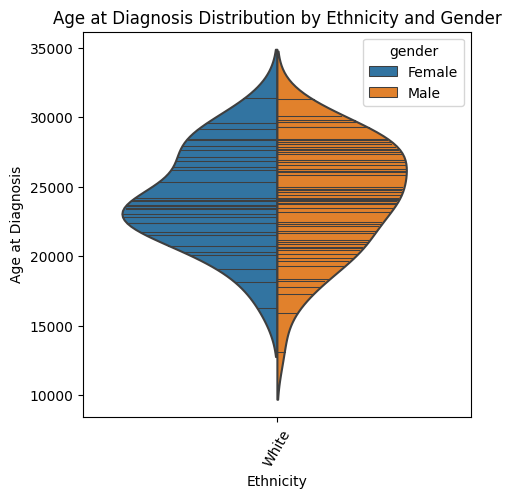

In [17]:
# Create a violin plot
plt.figure(figsize=(5, 5))
sns.violinplot(
    x="race", y="age_at_diagnosis", hue="gender", data=wide_pc[wide_pc.race.isin(["White"])], inner="stick", split=True
)
plt.title("Age at Diagnosis Distribution by Ethnicity and Gender")
plt.xlabel("Ethnicity")
plt.ylabel("Age at Diagnosis")
plt.xticks(rotation=60)
plt.show()

In [18]:
# Similar to before, let's say individuals who did not die, lived until the current US life expectancy age
maximum_days_before_death_from_data = wide_pc["days_to_death"].max()
wide_pc["days_to_death"] = wide_pc["days_to_death"].fillna(life_expectency_in_days - wide_pc["age_at_diagnosis"])

In [19]:
wide_pc.tissue_or_organ_of_origin.value_counts(dropna=False)

Head of pancreas                  78
Tail of pancreas                  12
Body of pancreas                  11
Pancreas, NOS                      9
Overlapping lesion of pancreas     1
Name: tissue_or_organ_of_origin, dtype: int64

By comparing the average expression levels of various genes between the alive and dead groups, we can identify genes that are differentially expressed. Genes that show significant differences in expression between these groups may be associated with survival or mortality.

In [20]:
def plot_differentially_expression_heatmap(cancer_specific_dataframe, distance_expressed):
    # Get a list of columns starting with 'r_'; these are columns related to RNA and their normalized expression levels
    prefix = "r_"
    gene_columns = [col for col in cancer_specific_dataframe.columns if col.startswith(prefix)]
    cancer_specific_dataframe = cancer_specific_dataframe[gene_columns + ["days_to_death"]]

    # Split the DataFrame into two based on 'days_to' condition
    df_below_cutoff = cancer_specific_dataframe[cancer_specific_dataframe["days_to_death"] < cutoff]
    df_above_cutoff = cancer_specific_dataframe[cancer_specific_dataframe["days_to_death"] >= cutoff]

    # Calculate the average of 'r_' features for both DataFrames
    avg_below_cutoff = df_below_cutoff.filter(like="r_").mean(skipna=False)
    avg_above_cutoff = df_above_cutoff.filter(like="r_").mean(skipna=False)

    # Create a new DataFrame to hold the averages

    average_df = pd.DataFrame({"below": avg_below_cutoff, "above": avg_above_cutoff})
    average_df = average_df[abs(average_df.below - average_df.above) > distance_expressed]
    average_df = average_df.rename(
        columns={"below": f"Death Before_{cutoff} days", "above": f" Alive After_{cutoff} days"}
    )

    fig = plt.figure()
    g = sns.clustermap(
        average_df,
        cmap="coolwarm",
        dendrogram_ratio=(0.2, 0.2),
        cbar_pos=None,
        row_cluster=True,
        col_cluster=False,
        yticklabels=True,
        figsize=(10, 20),
    )
    plt.title(f"Average expression of genes using {cutoff} days as a cutoff")
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=5)
    plt.show()

<Figure size 640x480 with 0 Axes>

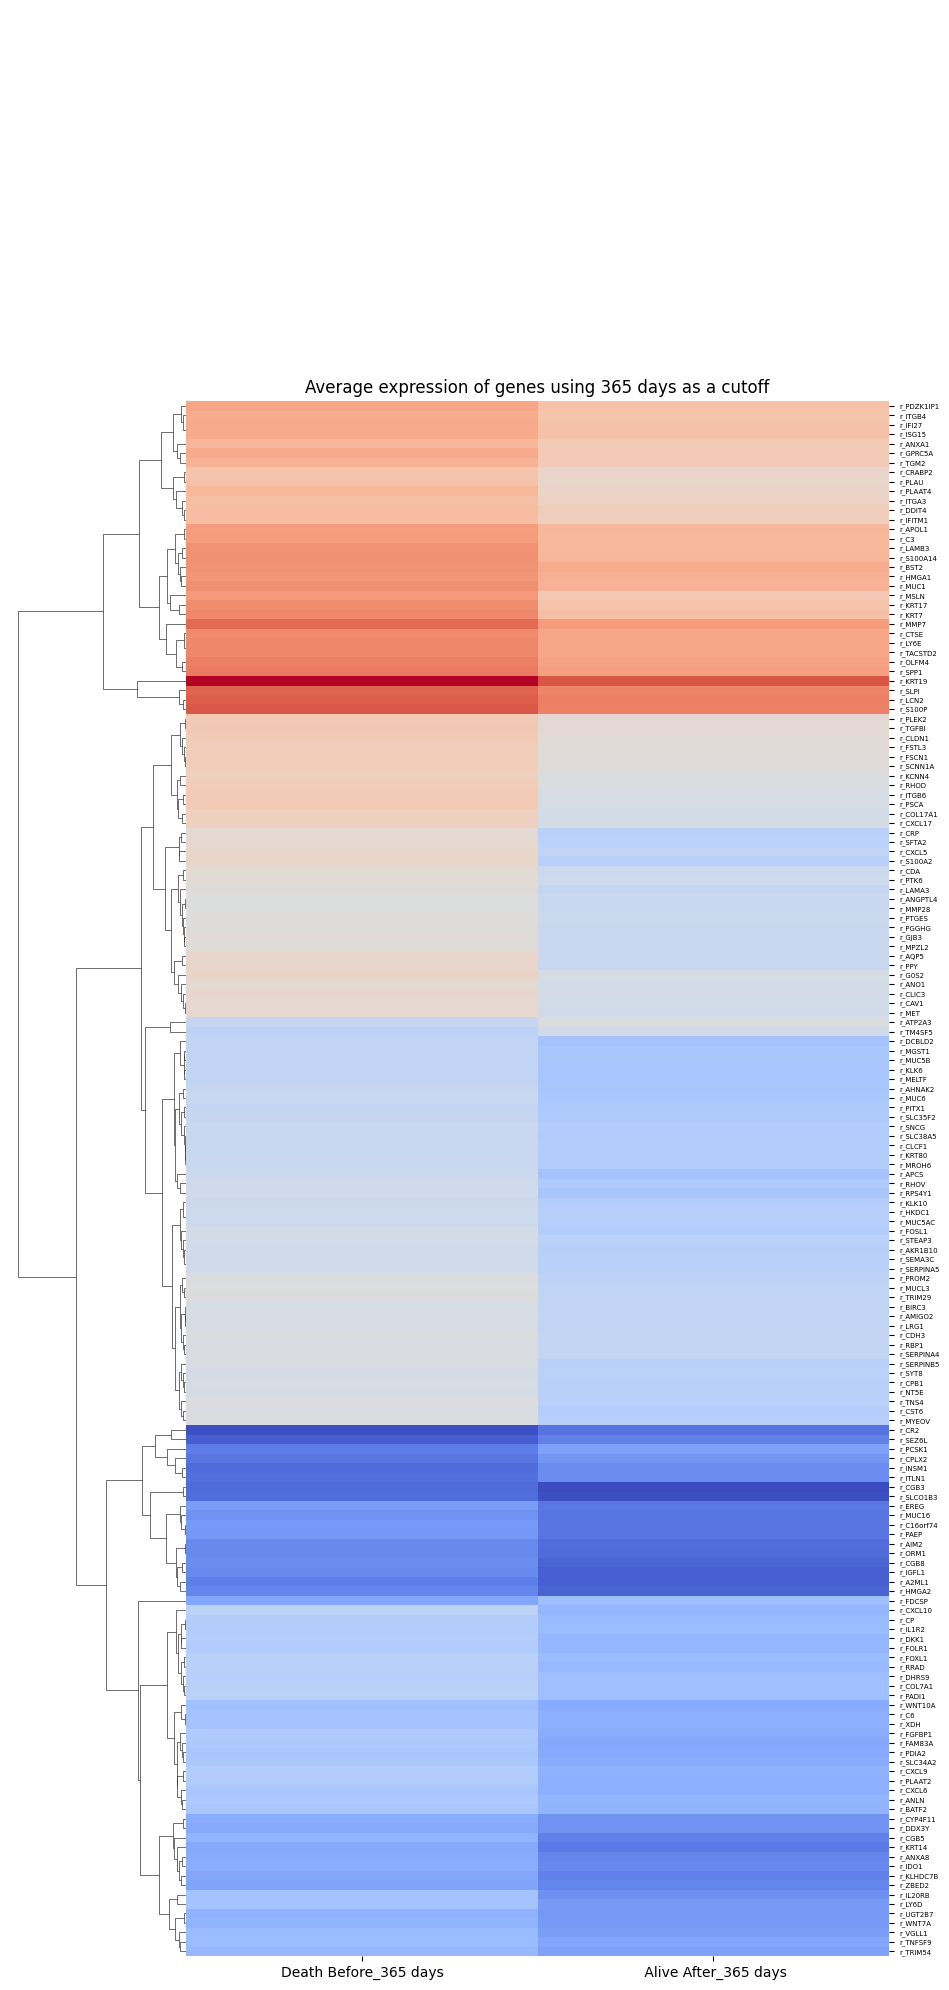

In [21]:
cutoff = DAYS_IN_YEAR
plot_differentially_expression_heatmap(wide_pc, distance_expressed=0.5)